In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys  
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir
tweets_dir  = "/Users/caihao/Dropbox/TEMP/tweets/"

In [2]:
# read company info and tweets dataframe.
df = pd.read_csv(processed_data_dir + '/companies_2014_labeled.csv')
df_tweets = pd.read_csv(processed_data_dir + '/company_tweets_stats_all.csv')
print(len(df), len(df_tweets))

df_new = pd.concat([df, df_tweets], axis=1)
df_new.count()

4473 4473


permalink                       4473
name                            4473
homepage_url                    4461
category_list                   4464
market                          4464
funding_total_usd               4473
status                          4374
country_code                    4160
state_code                      2898
region                          4160
city                            4133
funding_rounds                  4473
founded_at                      4242
founded_month                   4240
founded_quarter                 4240
founded_year                    4240
first_funding_at                4473
last_funding_at                 4473
twitter_username                4473
first2last_funding_days         4473
twit_since                      4473
twit_until                      4473
WILL                            3847
days_since_series_a             4473
WHEN                            2329
series_a_date                   4473
preA_timespan                   2670
p

In [3]:
# correlation index of all feature to see the importance of tweets data.
# feature engineering.
df = df_new.dropna(subset=['WILL']).copy()
df['funding_total_usd']
df['status_feature'] = df['status'].map({'closed': 0, 'operating': 1, 'acquired': 2}).fillna(0)
df['country_feature'] = df['country_code'].apply(lambda x: 1 if x=='USA' else 0)
df['age_feature'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.founded_at)).dt.days
df['age_feature'] = df['age_feature'].fillna(df['age_feature'].mean())
# df['funding_rounds']
df['days_since_first_funding'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.first_funding_at)).dt.days
# df['days_since_last_funding'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.last_funding_at)).dt.days
df['all_tweet_num'] = df['all_tweet_num'].fillna(0)
df['preA_tweet_num'] = df['preA_tweet_num'].fillna(0)
df['postA_tweet_num'] = df['postA_tweet_num'].fillna(0)
df['preA_tweet_freq'] = df['preA_tweet_freq'].fillna(0)
df['postA_tweet_freq'] = df['postA_tweet_freq'].fillna(0)
df['preA_tweet_avglength'] = df['preA_tweet_avglength'].fillna(0)
df['postA_tweet_avglength'] = df['postA_tweet_avglength'].fillna(0)
df['preA_tweet_content_richness'] = df['preA_tweet_content_richness'].fillna(0)
df['postA_tweet_content_richness'] = df['postA_tweet_content_richness'].fillna(0)
df['preA_tweet_interactiveness'] = df['preA_tweet_interactiveness'].fillna(0)
df['postA_tweet_interactiveness'] = df['postA_tweet_interactiveness'].fillna(0)
df['WILL'] = df['WILL'].astype(int)
df_corr = df[['country_feature', 'age_feature', \
              'days_since_first_funding', 'all_tweet_num', 'preA_tweet_num', 'postA_tweet_num', \
              'preA_tweet_freq', 'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength', \
              'preA_tweet_content_richness', 'postA_tweet_content_richness', 'preA_tweet_interactiveness', \
              'postA_tweet_interactiveness', 'WILL']].copy()
df_corr.count()

country_feature                 3847
age_feature                     3847
days_since_first_funding        3847
all_tweet_num                   3847
preA_tweet_num                  3847
postA_tweet_num                 3847
preA_tweet_freq                 3847
postA_tweet_freq                3847
preA_tweet_avglength            3847
postA_tweet_avglength           3847
preA_tweet_content_richness     3847
postA_tweet_content_richness    3847
preA_tweet_interactiveness      3847
postA_tweet_interactiveness     3847
WILL                            3847
dtype: int64

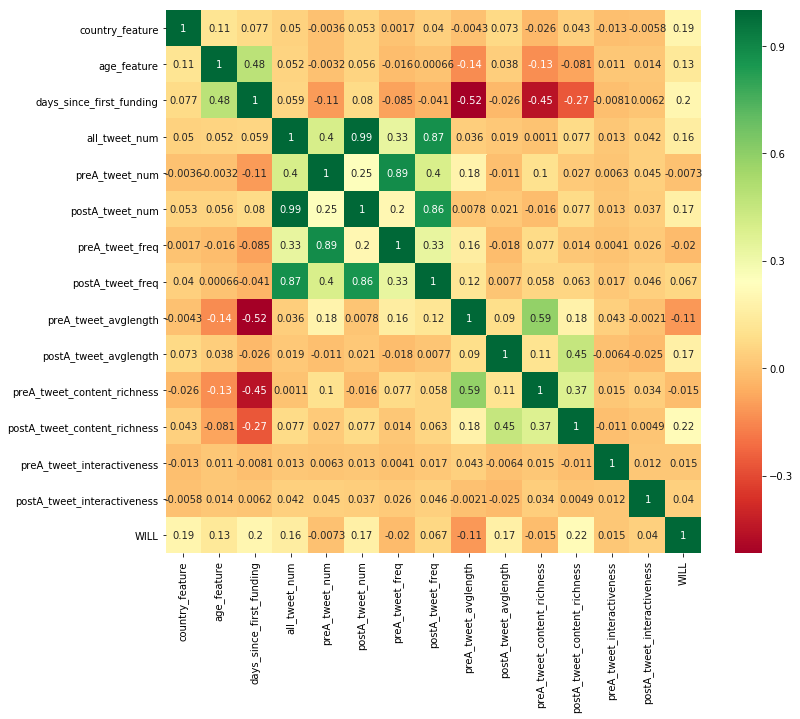

In [4]:
import numpy as np
import seaborn as sns

#get correlations of each features in dataset
plt.figure(figsize=(12, 10))
g=sns.heatmap(df_corr.corr(),annot=True,cmap="RdYlGn")

We see that tweet features are quite important among all features. Next I want to define more features based on their tweet content.

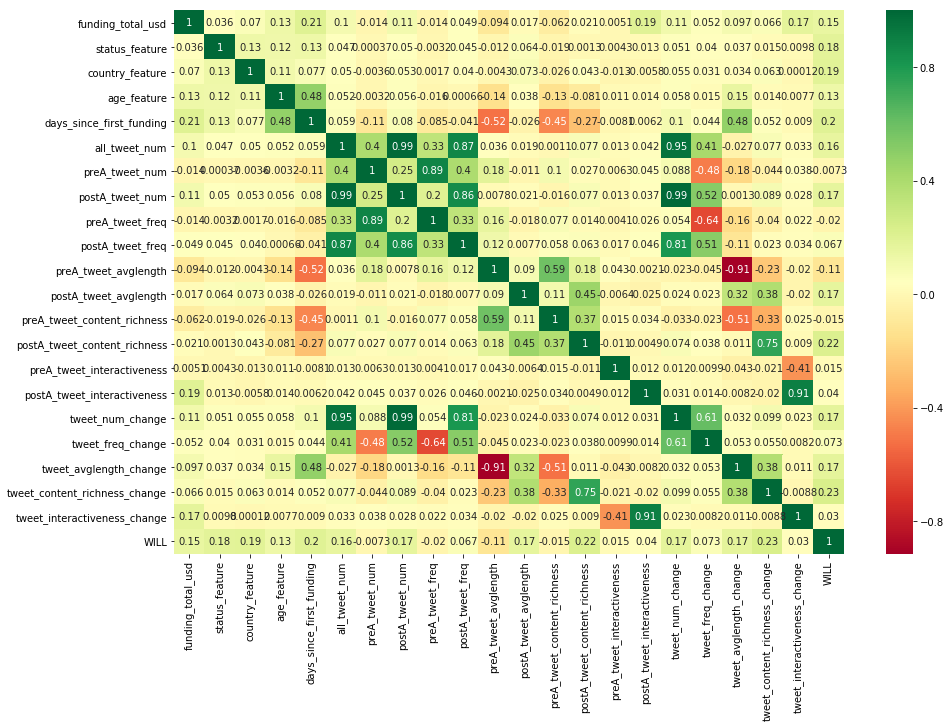

In [5]:
# more numerical features based on pre-/post- series A tweet difference.
df['tweet_num_change'] = df['postA_tweet_num'] - df['preA_tweet_num']
df['tweet_freq_change'] = df['postA_tweet_freq'] - df['preA_tweet_freq']
df['tweet_avglength_change'] = df['postA_tweet_avglength'] - df['preA_tweet_avglength']
df['tweet_content_richness_change'] = df['postA_tweet_content_richness'] - df['preA_tweet_content_richness']
df['tweet_interactiveness_change'] = df['postA_tweet_interactiveness'] - df['preA_tweet_interactiveness']
df['WILL'] = df['WILL'].astype(int)
df_corr = df[['funding_total_usd', 'status_feature', 'country_feature', 'age_feature', \
              'days_since_first_funding', 'all_tweet_num', 'preA_tweet_num', 'postA_tweet_num', \
              'preA_tweet_freq', 'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength', \
              'preA_tweet_content_richness', 'postA_tweet_content_richness', 'preA_tweet_interactiveness', \
              'postA_tweet_interactiveness', 'tweet_num_change', 'tweet_freq_change', 'tweet_avglength_change', \
              'tweet_content_richness_change', 'tweet_interactiveness_change', 'WILL']].copy()
plt.figure(figsize=(15, 10))
g=sns.heatmap(df_corr.corr(),annot=True,cmap="RdYlGn")
# df.to_csv(processed_data_dir + '/companies_all_labeled_2.csv', index=False)
df = pd.read_csv(processed_data_dir + '/companies_all_labeled_2.csv')

In [6]:
# tweet content features based on category_list and market_list. look at the categories and markets and think of \
# ways to do numerical transformation on them.
import re
import spacy
import pickle
from collections import Counter

def get_categories(df):
    all_categories = []
    for category_list in df.category_list.fillna('|').tolist():
        categories = re.split('\||\+', category_list)
        for category in categories:
            all_categories.append(category)
    return dict(Counter(all_categories))

def get_markets(df):
    all_markets = []
    for market in df.market.fillna('+').tolist():
        markets = re.split('\+', market)
        for market_ in markets:
            all_markets.append(market_)
    return dict(Counter(all_markets))

pos_categories = get_categories(df[df.WILL==1.0])
neg_categories = get_categories(df[df.WILL==0.0])
pos_markets = get_markets(df[df.WILL==1.0])
neg_markets = get_markets(df[df.WILL==0.0])

In [7]:
# save positive and negative counts for category/market.
def get_counts(pos_dict, neg_dict):
    counts = {'key':[], 'positive_count':[], 'negative_count':[], 'total_count':[], 'pos_minus_neg_count':[]}
    for key in set(pos_dict)|set(neg_dict):
        if len(key)>0:
            if key in pos_dict:
                pos_count = pos_dict[key]
            else:
                pos_count = 0
            if key in neg_dict:
                neg_count = neg_dict[key]
            else:
                neg_count = 0
            counts['key'].append(key)
            counts['positive_count'].append(pos_count)
            counts['negative_count'].append(neg_count)
            counts['total_count'].append(pos_count + neg_count)
            counts['pos_minus_neg_count'].append(pos_count - neg_count)
    counts_df = pd.DataFrame(counts)
    return counts_df

category_counts = get_counts(pos_categories, neg_categories)\
                    .sort_values(by=['pos_minus_neg_count', 'total_count'], ascending=False)\
                    .reset_index(drop=True)

market_counts = get_counts(pos_markets, neg_markets)\
                    .sort_values(by=['pos_minus_neg_count', 'total_count'], ascending=False)\
                    .reset_index(drop=True)

# category_counts.to_csv(processed_data_dir + '/category_counts.csv', index=False)
# market_counts.to_csv(processed_data_dir + '/market_counts.csv', index=False)
category_counts = pd.read_csv(processed_data_dir + '/category_counts.csv')
market_counts = pd.read_csv(processed_data_dir + '/market_counts.csv')
print(len(category_counts))
print(len(market_counts))

606
447


In [8]:
category_counts.head()

,key,positive_count,negative_count,total_count,pos_minus_neg_count
0,Software,435,214,649,221
1,Enterprise Software,227,95,322,132
2,Mobile,360,235,595,125
3,Advertising,227,122,349,105
4,Analytics,155,53,208,102


In [9]:
# Engineering of "category score" feature and "market score" feature was done in scripts.feature_engineering_nlp
# TODO: include "category score" and "market score" in the model!

category_scores = pd.read_csv(processed_data_dir + '/companies_all_category_scores_quick.txt',\
                              delimiter='\s+',\
                              names=['category_score'],\
                              index_col=0,)
market_scores = pd.read_csv(processed_data_dir + '/companies_all_market_scores_quick.txt',\
                            delimiter='\s+',\
                            names=['market_score'],\
                            index_col=0)
print(len(category_scores))
print(len(market_scores))
print(len(df))

df['category_score'] = category_scores
df['market_score'] = market_scores

# df_corr = df[['country_feature', 'age_feature', \
#               'days_since_first_funding', 'all_tweet_num', 'preA_tweet_num', 'postA_tweet_num', \
#               'preA_tweet_freq', 'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength', \
#               'preA_tweet_content_richness', 'postA_tweet_content_richness', 'preA_tweet_interactiveness', \
#               'postA_tweet_interactiveness', 'category_score','market_score', 'WILL']].copy()
# plt.figure(figsize=(12, 10))
# g=sns.heatmap(df_corr.corr(),annot=True,cmap="RdYlGn")

3847
3847
3847


Engineering of tweet-related feature features. One feature is "tweet topic score"; another feature is "tweet sentiment score". Details of these scores are in /scripts/nlp_tweets.py.

In [10]:
# Engineering of "tweet topic score" and "tweet emotion score".
# First, look at how many post-first-round tweets do successful and unsuccessful startups post.
# I decide to only look at 100 tweets from one company after their first round of funding.

pos_companies = df[(df.WILL == 1.0) & (df.postA_tweet_num>100)].copy()
neg_companies = df[(df.WILL == 0.0) & (df.postA_tweet_num>100)].copy()

print(pos_companies.all_tweet_num.count()) # successful
print(neg_companies.all_tweet_num.count()) # unsuccessful
print(df.all_tweet_num.count()) # all companies

2029
908
3847


Implementing topic modeling on tweets.

In [11]:
# retrieve all tweets for positive companies, negative companies and all companies.
pos_tweets = pd.read_csv(processed_data_dir + '/tweets_positive.csv').rename(columns={'0':'tweets'})
neg_tweets = pd.read_csv(processed_data_dir + '/tweets_negative.csv').rename(columns={'0':'tweets'})
all_tweets = pd.read_csv(processed_data_dir + '/tweets_all.csv').fillna('').rename(columns={'0':'tweets'})

print(pos_tweets.count())
print(neg_tweets.count())
print(all_tweets.count())

index     2029
tweets    2029
dtype: int64
index     908
tweets    908
dtype: int64
index     3847
tweets    3847
dtype: int64


In [12]:
# calculated the tweet topic score for all companies (done in '/scripts/nlp_tweets_topic.py').
tweets_topic_scores = pd.read_csv(processed_data_dir + '/companies_tweets_topic_scores.txt',\
                                  delimiter='\s+',\
                                  names=['tweets_neg_topic_score', 'tweets_pos_topic_score'],\
                                  index_col=0,)

In [13]:
# TODO: include tweets topic score in the model!

print(tweets_topic_scores.count())
df['tweets_pos_topic_score'] = tweets_topic_scores['tweets_pos_topic_score']
df['tweets_neg_topic_score'] = tweets_topic_scores['tweets_neg_topic_score']
df.columns

tweets_neg_topic_score    3847
tweets_pos_topic_score    3847
dtype: int64


Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username', 'first2last_funding_days',
       'twit_since', 'twit_until', 'WILL', 'days_since_series_a', 'WHEN',
       'series_a_date', 'preA_timespan', 'postA_timespan', 'all_tweet_num',
       'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',
       'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',
       'preA_tweet_content_richness', 'postA_tweet_content_richness',
       'preA_tweet_interactiveness', 'postA_tweet_interactiveness',
       'status_feature', 'country_feature', 'age_feature',
       'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',
       'tweet_avglength_change', 'tweet_content_richness_change',
       'tweet_interactiv

Exploration on sentimental analysis

In [14]:
# NLTK sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentence = 'oronto-based biotech startup @Cyclica has announced the launch of its drug discovery platform designed to help pharmaceutical scientists generate new drug-like compounds.'
sid.polarity_scores(sentence)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/caihao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'compound': 0.4019}

In [15]:
# calculated the tweet sentiment score for all companies (done in '/scripts/nlp_tweets_sentiment.py').
tweets_sentiment_scores = pd.read_csv(processed_data_dir + '/companies_tweets_sentiment_scores.txt',\
                                      delimiter='\s+',\
                                      names=['username', 'tweets_neg_sent_score', 'tweets_neu_sent_score', \
                                             'tweets_pos_sent_score', 'tweets_compound_sent_score']).fillna(0)
tweets_sentiment_scores.count()

username                      3847
tweets_neg_sent_score         3847
tweets_neu_sent_score         3847
tweets_pos_sent_score         3847
tweets_compound_sent_score    3847
dtype: int64

In [16]:
# TODO: include tweets sentiment score in the model!

df['tweets_neg_sent_score'] = tweets_sentiment_scores['tweets_neg_sent_score']
df['tweets_neu_sent_score'] = tweets_sentiment_scores['tweets_neu_sent_score']
df['tweets_pos_sent_score'] = tweets_sentiment_scores['tweets_pos_sent_score']
df['tweets_compound_sent_score'] = tweets_sentiment_scores['tweets_compound_sent_score']

df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username', 'first2last_funding_days',
       'twit_since', 'twit_until', 'WILL', 'days_since_series_a', 'WHEN',
       'series_a_date', 'preA_timespan', 'postA_timespan', 'all_tweet_num',
       'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',
       'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',
       'preA_tweet_content_richness', 'postA_tweet_content_richness',
       'preA_tweet_interactiveness', 'postA_tweet_interactiveness',
       'status_feature', 'country_feature', 'age_feature',
       'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',
       'tweet_avglength_change', 'tweet_content_richness_change',
       'tweet_interactiv

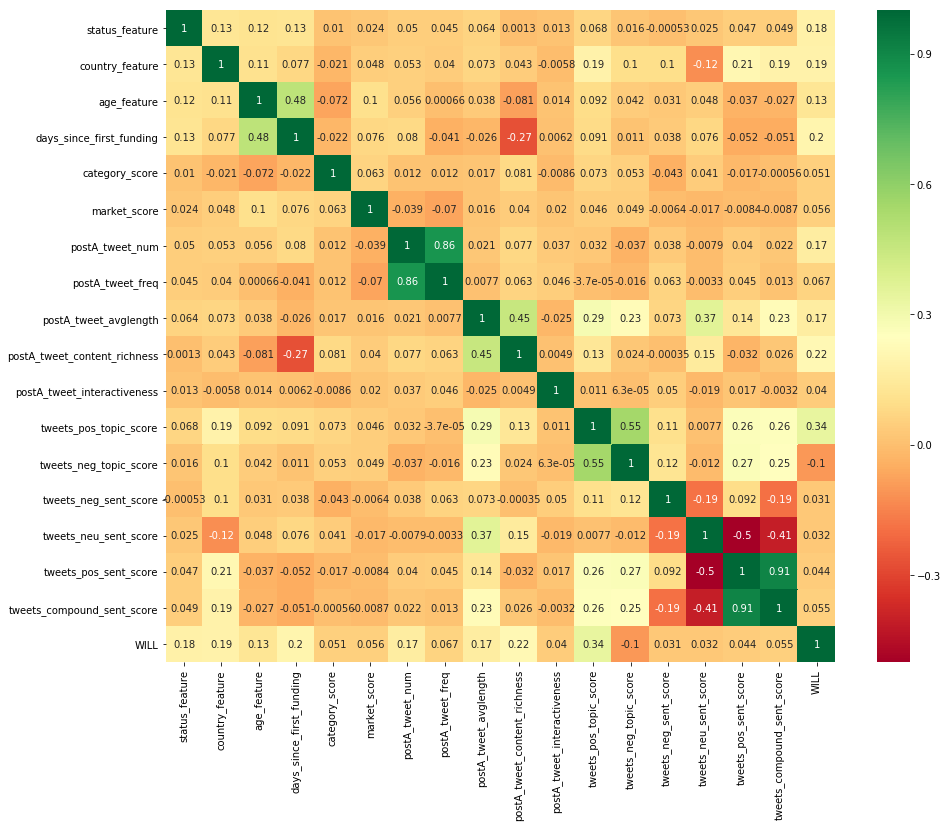

In [18]:
# see how different features correlates with the results.
# selected_features = ['funding_total_usd', 'all_tweet_num',\
#                      'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',\
#                      'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',\
#                      'preA_tweet_content_richness', 'postA_tweet_content_richness',\
#                      'preA_tweet_interactiveness', 'postA_tweet_interactiveness',\
#                      'status_feature', 'country_feature', 'age_feature',\
#                      'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',\
#                      'tweet_avglength_change', 'tweet_content_richness_change',\
#                      'tweet_interactiveness_change', 'category_score', 'market_score',\
#                      'tweets_pos_topic_score', 'tweets_neg_topic_score',\
#                      'tweets_neg_sent_score', 'tweets_neu_sent_score',\
#                      'tweets_pos_sent_score', 'tweets_compound_sent_score',\
#                      'WILL',]
selected_features = ['status_feature', 'country_feature', 'age_feature',\
                     'days_since_first_funding', 'category_score', 'market_score',\
                     'postA_tweet_num',\
                     'postA_tweet_freq', 'postA_tweet_avglength',\
                     'postA_tweet_content_richness',\
                     'postA_tweet_interactiveness',\
                     'tweets_pos_topic_score', 'tweets_neg_topic_score',\
                     'tweets_neg_sent_score', 'tweets_neu_sent_score',\
                     'tweets_pos_sent_score', 'tweets_compound_sent_score',\
                     'WILL',]
df_corr = df[selected_features].copy()
plt.figure(figsize=(15, 12))
g=sns.heatmap(df_corr.corr(),annot=True,cmap="RdYlGn")

In [22]:
# save the new dataframe to csv file.
print(df.columns)
print(df.count())
# df.to_csv(processed_data_dir + '/companies_all_labeled_final.csv', index=False)

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username', 'first2last_funding_days',
       'twit_since', 'twit_until', 'WILL', 'days_since_series_a', 'WHEN',
       'series_a_date', 'preA_timespan', 'postA_timespan', 'all_tweet_num',
       'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',
       'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',
       'preA_tweet_content_richness', 'postA_tweet_content_richness',
       'preA_tweet_interactiveness', 'postA_tweet_interactiveness',
       'status_feature', 'country_feature', 'age_feature',
       'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',
       'tweet_avglength_change', 'tweet_content_richness_change',
       'tweet_interactiv